In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model

In [40]:
from sklearn.feature_extraction import DictVectorizer
import itertools
def get_exog(X):
    vec = DictVectorizer()
    return vec.fit_transform(X.T.to_dict().values()).toarray()

def forward_feature_selection(X,y, fit_model, scorer):
    # X and y pandas data frame / series
    # fit_model function returns a fitted model to be passed to the scorer
    # scorer function returns score to be used in selection
    # returns list of (score, features_set)
    features = []
    results = []
    candidates = list(X.columns)
    #import pdb; pdb.set_trace()
    for d in range(len(candidates)):
        scores = {}
        for candidate in candidates:
            cols = features + [candidate]
            exog = get_exog(X[cols])
            model = fit_model(exog, y.values)
            scores[candidate] = scorer(model, exog, y.values)
        best_feature= max(scores.keys(), key=scores.get)
        features.append(best_feature)
        candidates.remove(best_feature)
        results.append((tuple(features),scores[best_feature]))
    return results


def best_subset_selection(X,y, fit_model, scorer):
    results = []
    factors = list(X.columns)
    for d in range(1, len(factors)+1):
        scores = {}
        for candidate in itertools.combinations(factors, d):
            cols = list(candidate)
            exog = get_exog(X[cols])
            model = fit_model(exog, y.values)
            scores[candidate] = scorer(model, exog, y.values)
        best_set = max(scores.keys(), key=scores.get)
        results.append((best_set,scores[best_set]))
    return results

def fit_model(exog,endog):
    # returns fitted model object to be passed to the scorer
    return linear_model.LinearRegression().fit(exog,endog)

def MSE(model, X, y):
    # returns negated Mean Squared Error (to be consistent with score maximization)
    return - ((model.predict(X) - y)**2).mean()

In [41]:
Credit = pd.read_csv('../Data/Credit.csv')
del Credit['Unnamed: 0']

In [42]:
Credit.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [70]:
y = Credit['Balance']
X = Credit.drop('Balance', axis=1)

In [71]:
forward_selection_models = forward_feature_selection(X,y, fit_model, MSE)

In [72]:
best_subset_models = best_subset_selection(X,y,fit_model,MSE)

In [73]:
best_subset_models[0:4]

[(('Rating',), -53587.805081832368),
 (('Income', 'Rating'), -26331.353225424053),
 (('Income', 'Rating', 'Student'), -10568.048276516316),
 (('Income', 'Limit', 'Cards', 'Student'), -9787.6461877432121)]

In [74]:
# all Costs are returned as negative to stay consistent with scorer maximization
from math import log
def Cp(model, X, y, d):
    residuals = (y - model.predict(X))**2
    sigma = residuals.mean()
    RSS = sum(residuals)
    n = len(y)
    return -(RSS + 2*d*sigma)/n

def BIC(model, X, y, d):
    residuals = (y - model.predict(X))**2
    sigma = residuals.mean()
    RSS = sum(residuals)
    n = len(y)
    return -(RSS + log(n)*d*sigma)/(n)

def adjustedR2(model, X, y, d):
    residuals = (y - model.predict(X))**2
    y_mean = y.mean()
    TSS = sum((y-y_mean)**2)
    RSS = sum(residuals)
    sigma = residuals.mean()
    n = len(y)
    return 1 - (RSS/(n-d-1))/(TSS/(n-1))

In [75]:
lr = linear_model.LinearRegression().fit(Credit[['Income','Limit']].values,Credit['Balance'].values)

In [76]:
num_parameters = [len(x[0])+1 for x in best_subset_models]

In [102]:
# If you are fitting a categorical variable that requires multiple dummy variable encodings,
# does that count as 1 parameter or multiple?
BIC_scores = []
Cp_scores = []
adjustedR2_scores = []
y = Credit['Balance'].values
for params, score in best_subset_models:
    params = list(params)
    X = get_exog(Credit[params])
    lr = linear_model.LinearRegression().fit(X, y)
    BIC_scores.append(-BIC(lr, X,y, len(params)))
    Cp_scores.append(-Cp(lr, X,y, len(params)))
    adjustedR2_scores.append(adjustedR2(lr, X,y, len(params)))    

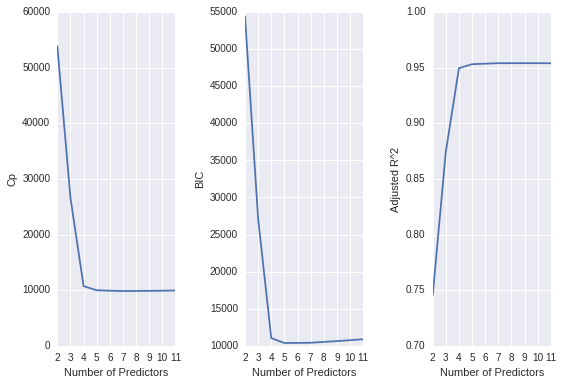

In [109]:
# I need to figure out this horizontal spacing in ipython notebooks...
f, (ax1, ax2, ax3) = plt.subplots(ncols=3)
ax1.plot(num_parameters, Cp_scores)
ax1.set_ylabel('Cp')
ax1.set_xlabel('Number of Predictors')
ax2.plot(num_parameters, BIC_scores)
ax2.set_ylabel('BIC')
ax2.set_xlabel('Number of Predictors')
ax3.plot(num_parameters, adjustedR2_scores)
ax3.set_ylabel('Adjusted R^2')
ax3.set_xlabel('Number of Predictors')
plt.tight_layout()

In [192]:
from sklearn.preprocessing import normalize
# I'm going to self-encode the binary variables and drop Ethnicity
X = Credit.drop('Balance', axis=1)
# the Gender column has some spaces in it
def gender_map(x):
    if x.strip() == 'Male':
        return 1
    elif x.strip() == 'Female':
        return 0
    else:
        raise ValueError("must be 'Male' or 'Female'")
X['Gender'] = X['Gender'].map(gender_map)
X['Student'] = X['Student'].map({'Yes':1, 'No': 0})
X['Married'] = X['Married'].map({'Yes':1, 'No': 0})
X = X.drop('Ethnicity', axis=1)
exog = normalize(X.values)
#exog = X.values
y = Credit['Balance'].values
y = (y-y.mean())/y.std()
X.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married
0,14.891,3606,283,2,34,11,1,0,1
1,106.025,6645,483,3,82,15,0,1,1
2,104.593,7075,514,4,71,11,1,0,0
3,148.924,9504,681,3,36,11,0,0,0
4,55.882,4897,357,2,68,16,1,0,1


In [201]:
# I'm having trouble recreating the plot in figure 6.4
n_alphas = 500
alphas = np.logspace(-5,-1,n_alphas)
clf = linear_model.Ridge()
coef_names = list(X.columns)
coefs = []


for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(exog,y)
    coefs.append(clf.coef_)

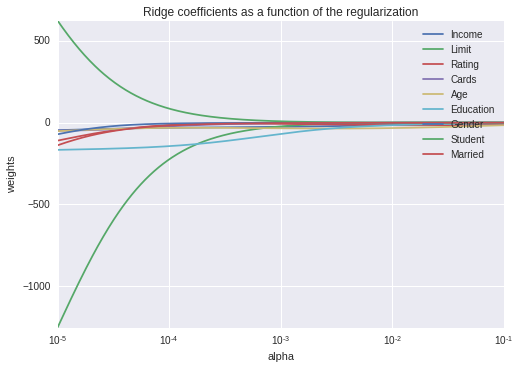

In [202]:

ax = plt.gca()
#ax.set_color_cycle(['b', 'r', 'g', 'c', 'k', 'y', 'm'])

ax.plot(alphas, coefs)
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.legend(coef_names)
plt.show()

In [212]:
# TODO: Figure 6.12 on page 228

In [222]:
a.cv_values_

AttributeError: 'RidgeCV' object has no attribute 'cv_values_'